# Qualche grafico da visualizzare

Analizziamo dei dati di AREU per cavarne un ragno dal buco. I dati sono disponibili pubblicamente sul [sito di AREU](https://www.areu.lombardia.it/web/home/missioni-aat-real-time). I dati storici sono stati ottenuti con un piccolo [script python](https://github.com/r-carissimi/areu-data-collector).
AREU è l'Agenzia Regionale Emergenza Urgenza, ovvero l'ente di Regione Lombardia che ha il compito di gestire, tra le altre cose, le chiamate al Numero Unico di Emergenza 112. Di fatto questi dati rappresentano le _missioni_ (ovvero gli interventi) riguardo al **soccorso sanitario in provincia di Milano**.

In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
from datetime import datetime, timedelta
import time

#Configurazioni globali di Matplotlib
%matplotlib inline
plt.style.use('bmh')
plt.rc('figure', figsize=(10.0, 10.0))

#Leggiamo il CSV
#df = pd.read_csv('../real-time-data/milano.csv')

In [2]:
provinces = ["bergamo", "brescia", "como", "cremona", "lecco", "lodi", "mantova", "milano", "monza", "pavia", "sondrio", "varese"]

def read_data(province: str):
	#Mettiamo il nome della provincia in lower case
	province = province.casefold()

	#Controlliamo che la provincia esista
	if (not provinces.__contains__(province)):
		print("La provincia non esiste")
		return None

	#Leggiamo il CSV
	data = pd.read_csv('../real-time-data/' + province + '.csv')

	#Creo delle colonne per analizzare meglio il tempo
	time = data["aggiornato_alle"] + " " + data["day_data"]
	data["timestamp"] = time.apply(lambda x: datetime.strptime(x, '%H:%M %d/%m/%Y'))
	data["weekday"] = data["timestamp"].apply(lambda x: x.strftime("%w"))
	data["hour"] = data["timestamp"].apply(lambda x: x.strftime("%H"))
	data["month"] = data["timestamp"].apply(lambda x: x.strftime("%m"))

	#Seleziono solo le colonne che mi interessano
	data = data.drop(["aggiornato_alle", "day_data"], axis=1)
	data = data.set_index(["timestamp", "aat"])
	return data

def read_all_data():
	data = read_data(provinces[1])
	for aat in provinces[1:]:
		data = pd.concat([data, read_data(aat)])
	return data


In [3]:
data = read_data("milano")


## Media di ambulanze per ogni giorno della settimana

Ora analizziamo la media delle ambulanze per ogni giorno della settimana, separando le statistiche per turno.

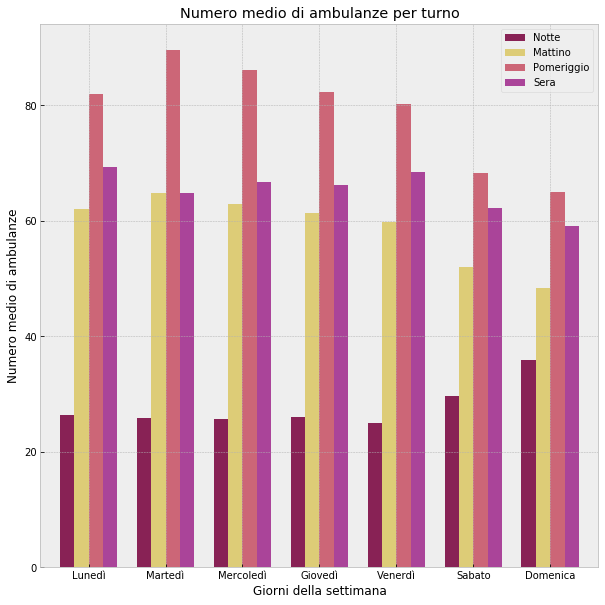

In [4]:
#Creiamo il dataframe contenente i dati che vogliamo analizzare
medie = data.copy()
medie["hour"] = medie["hour"].astype(int).floordiv(6);
medie = medie[["msb", "weekday", "hour"]].groupby(["weekday", "hour"]).mean().unstack(1)

#Cambiamo i valori del dataframe con nomi più appropiati
medie.rename(columns={0:"Notte",1:"Mattina",2:"Pomeriggio",3:"Sera"}, inplace=True)
medie.rename(index={"0":"7"}, inplace=True)
medie.sort_index(inplace=True)
medie.rename(index={"7":"Domenica","1":"Lunedì","2":"Martedì","3":"Mercoledì", "4":"Giovedì","5":"Venerdì","6":"Sabato"}, inplace=True)
ax = medie.plot(kind="bar", width=0.75, color=["#882255", "#DDCC77","#CC6677","#AA4499"], xlabel="Giorni della settimana", ylabel="Numero medio di ambulanze", title="Numero medio di ambulanze per turno")
ax.legend(["Notte", "Mattino", "Pomeriggio", "Sera"]);
plt.xticks(rotation=0)
plt.show()

Dividiamo il grafico nei codici colore. Notare che visto che dobbiamo considerare i codici colore ora stiamo parlando di _missioni_: la differenza è che ad una missione può essere assegnata più di un'ambulanza.

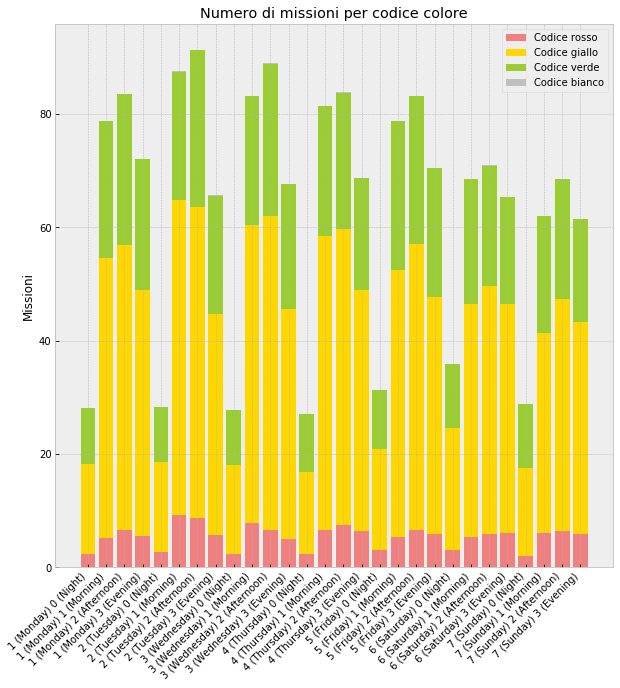

In [5]:
def turno(key):
	timestamp = key[0]
	weekday = timestamp.strftime("%u (%A)")
	hour = int(timestamp.strftime("%H"))
	if 0 <= hour < 8 : 
		hour = "0 (Night)"
		weekday = (timestamp-timedelta(days=1)).strftime("%u (%A)")
	elif 8 <= hour < 13 : hour = "1 (Morning)"
	elif 13 <= hour < 19 : hour = "2 (Afternoon)"
	elif 19 <= hour < 24 : hour = "3 (Evening)"
	return weekday + " " + hour

medie = data.groupby(by = turno).mean()
std = data.groupby(by = turno).std()

fig, ax = plt.subplots()
ax.bar(medie.index, medie.rosso, label = "Codice rosso", color = "#F08080")
ax.bar(medie.index, medie.giallo, label = "Codice giallo", color = "#FFD700", bottom=medie.rosso)
ax.bar(medie.index, medie.verde, label = "Codice verde", color = "#9ACD32", bottom=(medie.giallo+medie.rosso))
ax.bar(medie.index, medie.bianco, label = "Codice bianco", color = "#C0C0C0", bottom=(medie.giallo+medie.rosso+medie.verde))


ax.set_ylabel('Missioni')
ax.set_title('Numero di missioni per codice colore')
ax.legend()

plt.xticks(rotation=45, ha='right')
plt.show()

Aggiungiamo anche a questo grafico l'indicazione della deviazione standard per capire quanto il dato è variabile. La deviazione standard riguarda il totale delle missioni e non quelle legate al singolo codice colore.

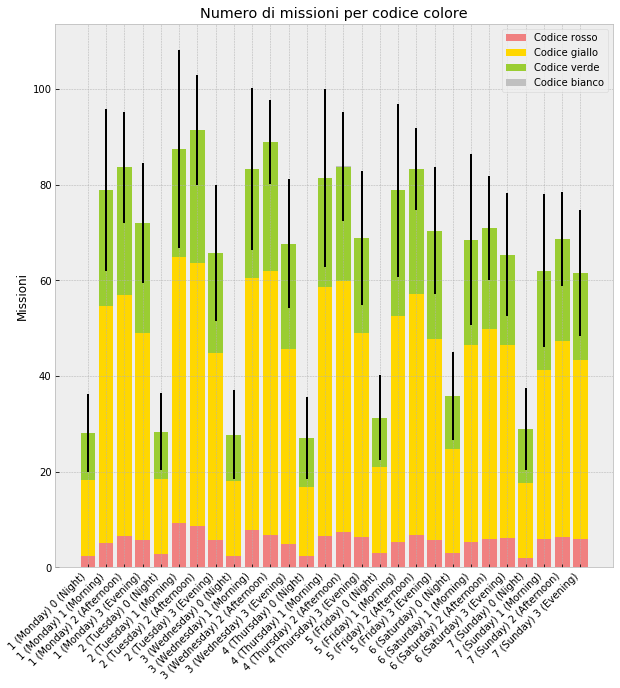

In [6]:
fig, ax = plt.subplots()
ax.bar(medie.index, medie.rosso, label = "Codice rosso", color = "#F08080")
ax.bar(medie.index, medie.giallo, label = "Codice giallo", color = "#FFD700", bottom=medie.rosso)
ax.bar(medie.index, medie.verde, label = "Codice verde", color = "#9ACD32", bottom=(medie.giallo+medie.rosso))
ax.bar(medie.index, medie.bianco, label = "Codice bianco", color = "#C0C0C0", bottom=(medie.giallo+medie.rosso+medie.verde), yerr=std.missioni)


ax.set_ylabel('Missioni')
ax.set_title('Numero di missioni per codice colore')
ax.legend()

plt.xticks(rotation=45, ha='right')
plt.show()

## Analizziamo ora per ora

Otteniamo le medie di tutti i valori per ogni orario del giorno e cerchiamo di cavarne qualche statistica interessante.

In [7]:
orari = data.groupby(by = data["hour"]).mean()
orari

,msb,msi,msa,elisoccorso,soccorso_alpino,soccorso_acqua,missioni,rosso,giallo,verde,...,guardia_medica,informazioni,consulenza,trasporto_organi,trasporto_prenotato,prestazione_ambulatoriale,da_richiamare,mezzi_altro,altro,totale_traffico_tel
hour,,,,,,,,,,,,,,,,,,,,,
00,37.773876,0.662921,1.546348,0.011236,0.0,0.0,40.036517,3.393258,23.410112,13.242978,...,0.0,0.000000,0.000000,0.761236,0.000000,0.000000,0.0,0.053371,0.00000,36.508427
01,32.500743,0.572065,1.687964,0.000000,0.0,0.0,34.786033,2.982169,20.111441,11.699851,...,0.0,0.000000,0.000000,0.772660,0.000000,0.000000,0.0,0.037147,0.00000,31.243685
02,27.687601,0.568438,1.578100,0.000000,0.0,0.0,29.838969,2.698873,16.370370,10.779388,...,0.0,0.000000,0.000000,0.858293,0.000000,0.000000,0.0,0.016103,0.00000,26.571659
03,24.038292,0.396171,1.097202,0.000000,0.0,0.0,25.541973,1.731959,14.181149,9.636230,...,0.0,0.000000,0.000000,0.801178,0.000000,0.000000,0.0,0.022091,0.00000,23.270987
04,22.599705,0.212703,1.048744,0.000000,0.0,0.0,23.856721,1.639586,13.039882,9.189069,...,0.0,0.000000,0.000000,0.859675,0.000000,0.000000,0.0,0.007386,0.00000,21.960118
05,22.309985,0.235469,1.047690,0.000000,0.0,0.0,23.588674,2.400894,12.764531,8.412817,...,0.0,0.000000,0.000000,0.816692,0.000000,0.000000,0.0,0.000000,0.00000,21.722802
06,24.997203,0.236364,0.983217,0.000000,0.0,0.0,26.205594,2.542657,14.489510,9.184615,...,0.0,0.000000,0.000000,0.819580,0.000000,0.000000,0.0,0.000000,0.00000,24.190210
07,30.879475,0.343675,1.103819,0.010740,0.0,0.0,32.326969,2.955847,18.897375,10.484487,...,0.0,0.000000,0.000000,0.772076,0.000000,0.000000,0.0,0.000000,0.00000,29.983294
08,48.143149,0.580777,1.591002,0.065440,0.0,0.0,50.380368,4.525562,29.402863,16.436605,...,0.0,0.000000,0.000000,0.758691,0.000000,0.000000,0.0,0.000000,0.00000,46.764826


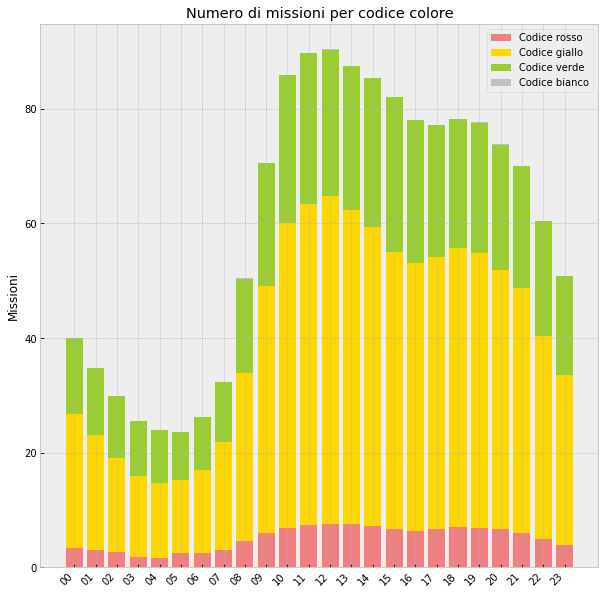

In [8]:
fig, ax = plt.subplots()
ax.bar(orari.index, orari.rosso, label = "Codice rosso", color = "#F08080")
ax.bar(orari.index, orari.giallo, label = "Codice giallo", color = "#FFD700", bottom=orari.rosso)
ax.bar(orari.index, orari.verde, label = "Codice verde", color = "#9ACD32", bottom=(orari.giallo+orari.rosso))
ax.bar(orari.index, orari.bianco, label = "Codice bianco", color = "#C0C0C0", bottom=(orari.giallo+orari.rosso+orari.verde))


ax.set_ylabel('Missioni')
ax.set_title('Numero di missioni per codice colore')
ax.legend()

plt.xticks(rotation=45, ha='right')
plt.show()

## Motivi di intervento
C'è qualcosa di interessante da notare sulla distribuzione oraria dei motivi di intervento?
Si! Ma purtroppo non riusciamo a notarlo con un grafico in cui li mostriamo tutti.

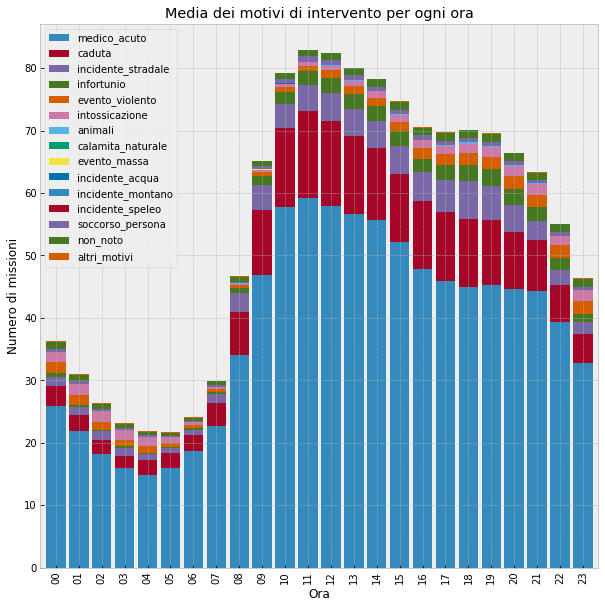

In [9]:
orari = data[["medico_acuto", "caduta", "incidente_stradale", "infortunio", "evento_violento", "intossicazione", "animali", "calamita_naturale", "evento_massa", "incidente_acqua", "incidente_montano", "incidente_speleo", "soccorso_persona", "non_noto", "altri_motivi"]]
orari = orari.groupby(by= data["hour"]).mean()
_ = orari.plot(kind="bar", stacked=True, width=0.85)
plt.ylabel('Numero di missioni')
plt.xlabel('Ora')
plt.title('Media dei motivi di intervento per ogni ora')
plt.show()

Dalla prossima visualizzazione impariamo che gli incidenti avvengono di più al ritorno da lavoro rispetto all'andata. In pausa pranzo nessuno si fa male.

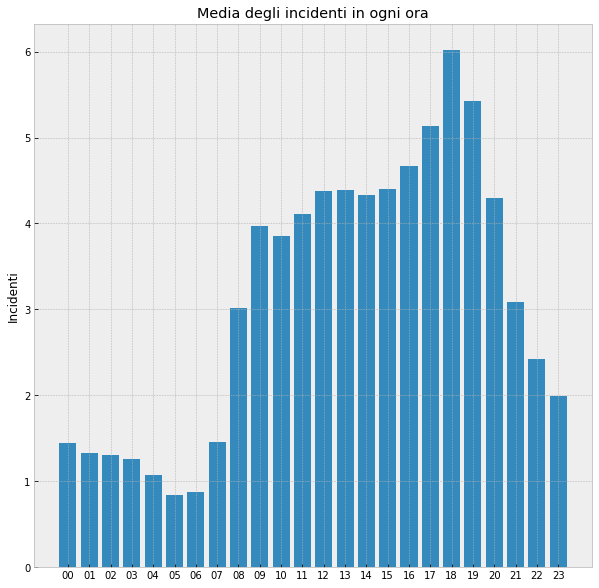

In [10]:
plt.bar(orari.index, orari.incidente_stradale)
plt.ylabel('Incidenti')
plt.title('Media degli incidenti in ogni ora')
plt.show()

È interessante vedere il prossimo grafico: i principali casi di intossicazione sono quelle etiliche (ovvero l'ubriacatura): come è normale aspettarsi la maggior parte di questi casi avvengono nelle ore notturne

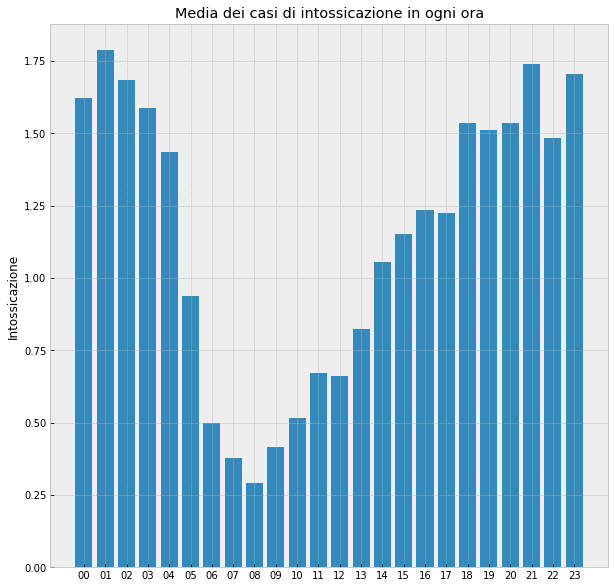

In [11]:
plt.bar(orari.index, orari.intossicazione)
plt.ylabel('Intossicazione')
plt.title('Media dei casi di intossicazione in ogni ora')
plt.show()

## Quando esce l'automedica?

Cerchiamo di capire la correlazione tra uscita dell'automedica e il tipo di evento.

[]

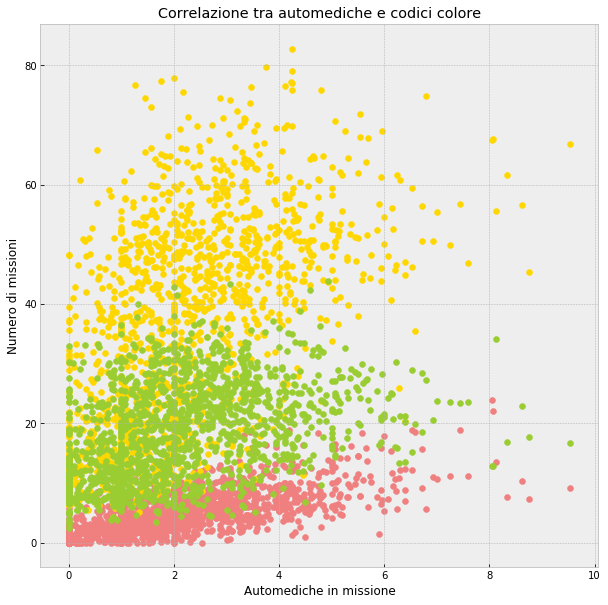

In [12]:
periodo = data.reset_index( level = [1] )
periodo["day"] = periodo.index.strftime("%Y-%m-%d")
periodo = periodo.groupby(by=["day","hour"]).mean()

plt.scatter(periodo["msa"], periodo["rosso"], color="#F08080")
plt.scatter(periodo["msa"], periodo["giallo"], color="#FFD700")
plt.scatter(periodo["msa"], periodo["verde"], color="#9ACD32")

plt.ylabel('Numero di missioni')
plt.xlabel('Automediche in missione')
plt.title('Correlazione tra automediche e codici colore')

plt.plot()

[]

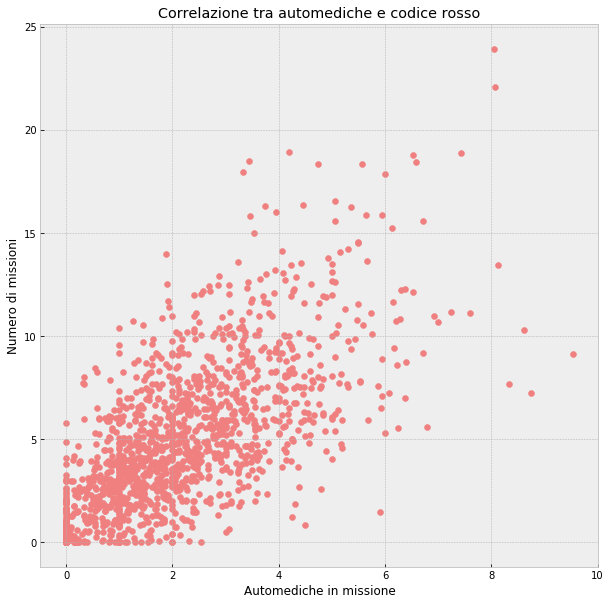

In [13]:
plt.scatter(periodo["msa"], periodo["rosso"], color="#F08080")

plt.ylabel('Numero di missioni')
plt.xlabel('Automediche in missione')
plt.title('Correlazione tra automediche e codice rosso')

plt.plot()

# Variabilità nei giorni della settimana

Usiamo i box plot per capire la varibilità dei dati nei giorni della settimana.

/home/riccardo/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


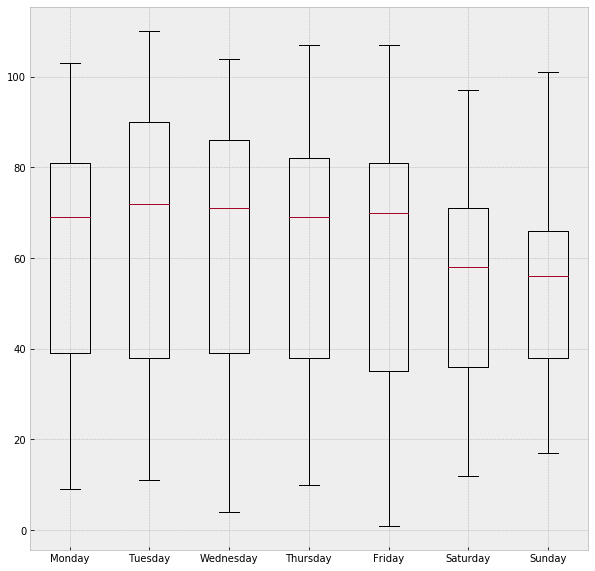

In [14]:
fig, ax = plt.subplots()
ax.boxplot([
	data[data["weekday"] == "1"]["msb"],
	data[data["weekday"] == "2"]["msb"],
	data[data["weekday"] == "3"]["msb"],
	data[data["weekday"] == "4"]["msb"],
	data[data["weekday"] == "5"]["msb"],
	data[data["weekday"] == "6"]["msb"],
	data[data["weekday"] == "0"]["msb"],
])
ax.set_xticklabels(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday",])
plt.show()

## Numero di missioni

Volevo plottare il numero di missioni in un giorno qualsiasi.

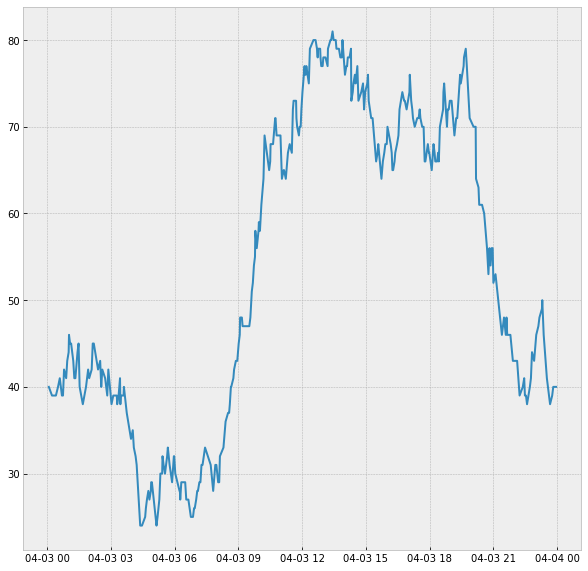

In [15]:
giornaliero = data.reset_index( level = [1] )
giornaliero["day"] = giornaliero.index.strftime("%Y-%m-%d")

plt.plot(giornaliero[giornaliero['day']=="2022-04-03"]["msb"])
plt.show()

## Ci sono differenze tra le province?
Analizziamo i dati di tutte le province aggregate o mettiamo a confronto i grafici più interessanti di province differenti

In [16]:
cumulative = read_all_data()
cumulative.head()

,,soreu,msb,msi,msa,elisoccorso,soccorso_alpino,soccorso_acqua,missioni,rosso,giallo,...,trasporto_organi,trasporto_prenotato,prestazione_ambulatoriale,da_richiamare,mezzi_altro,altro,totale_traffico_tel,weekday,hour,month
timestamp,aat,,,,,,,,,,,,,,,,,,,,,
2022-03-09 17:36:00,BRESCIA,ALPI,15,1,3,0,0,0,19,7,9,...,0,0,0,0,0,0,13,3,17,03
2022-03-09 18:14:00,BRESCIA,ALPI,18,1,4,1,0,0,24,9,10,...,0,0,0,0,0,0,17,3,18,03
2022-03-09 18:31:00,BRESCIA,ALPI,18,1,3,1,0,0,23,9,9,...,0,0,0,0,0,0,17,3,18,03
2022-03-09 18:37:00,BRESCIA,ALPI,18,2,3,1,0,0,24,9,10,...,0,0,0,0,0,0,18,3,18,03
2022-03-09 18:50:00,BRESCIA,ALPI,18,2,3,1,0,0,24,9,12,...,0,0,0,0,0,0,20,3,18,03


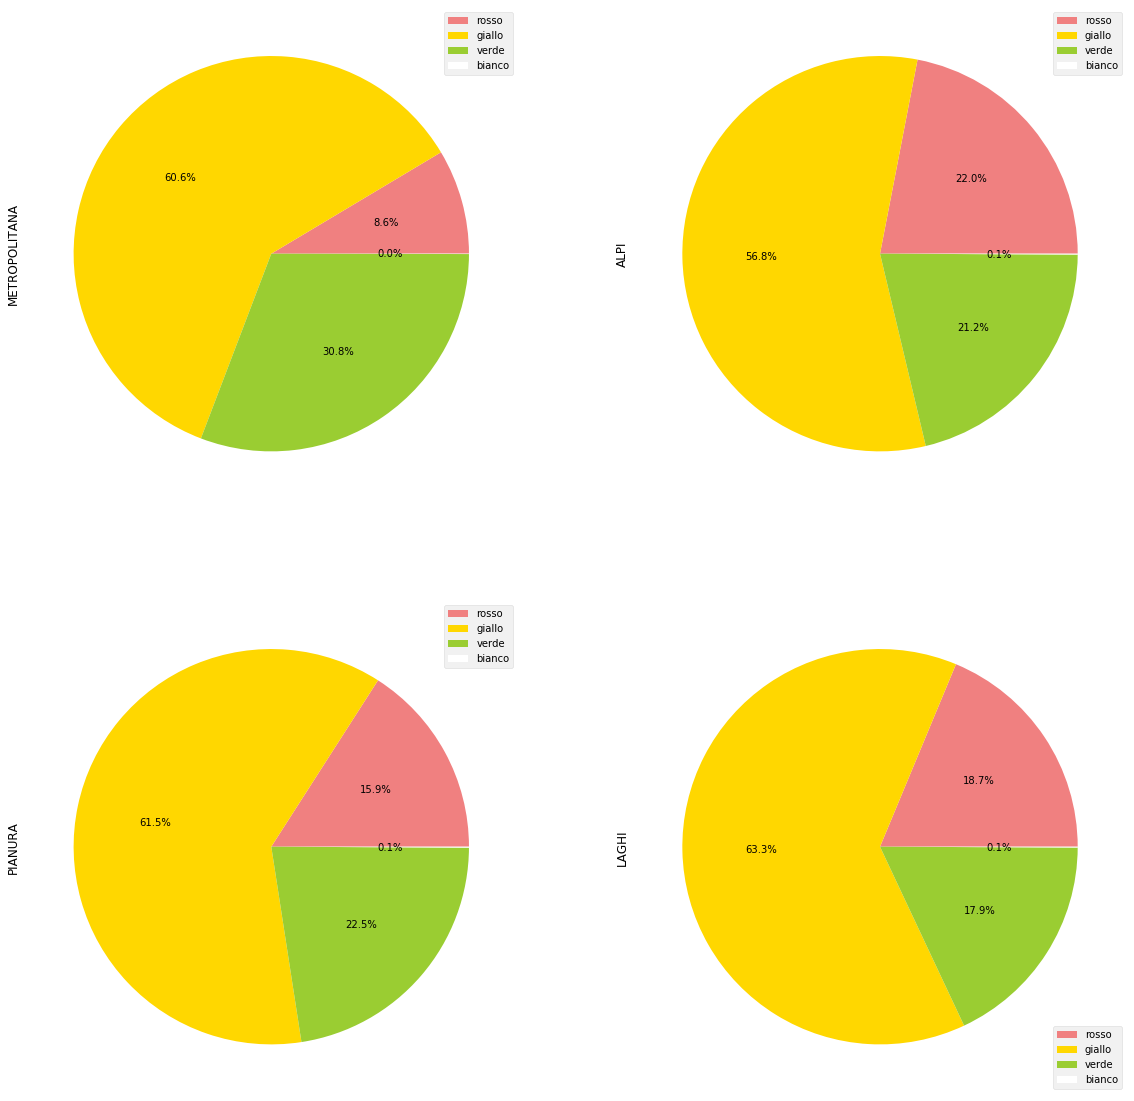

In [46]:
orari = cumulative[["rosso", "giallo", "verde", "bianco"]]
orari = orari.groupby(by= cumulative["soreu"]).mean()
orari = orari.transpose()

plt.rc('figure', figsize=(20.0, 20.0))
fig, axes = plt.subplots(nrows=2, ncols=2)

orari.plot(kind="pie", y="METROPOLITANA", colors=["#F08080", "#FFD700", "#9ACD32", "white"], ax=axes[0,0], autopct='%1.1f%%', labels=None)
orari.plot(kind="pie", y="ALPI", colors=["#F08080", "#FFD700", "#9ACD32", "white"], ax=axes[0,1], autopct='%1.1f%%', labels=None)
orari.plot(kind="pie", y="PIANURA", colors=["#F08080", "#FFD700", "#9ACD32", "white"], ax=axes[1,0], autopct='%1.1f%%', labels=None)
orari.plot(kind="pie", y="LAGHI", colors=["#F08080", "#FFD700", "#9ACD32", "white"], ax=axes[1,1], autopct='%1.1f%%', labels=None)

plt.show()

plt.rc('figure', figsize=(10.0, 10.0))

La prima differenza che vediamo è quella tra le SOREU: la metropolitana sembra sottostimare la gravità degli eventi.

Analizziamo invece quel calo di emergenze nel weekend: scopriremo che Milano non è la regola ma invece l'eccezione. Tutte le altre province non subiscono questo calo di eventi.
Ce ne sono due che ivece aumentano addirittura i propri casi: parliamo delle province di Sondrio e Lecco.

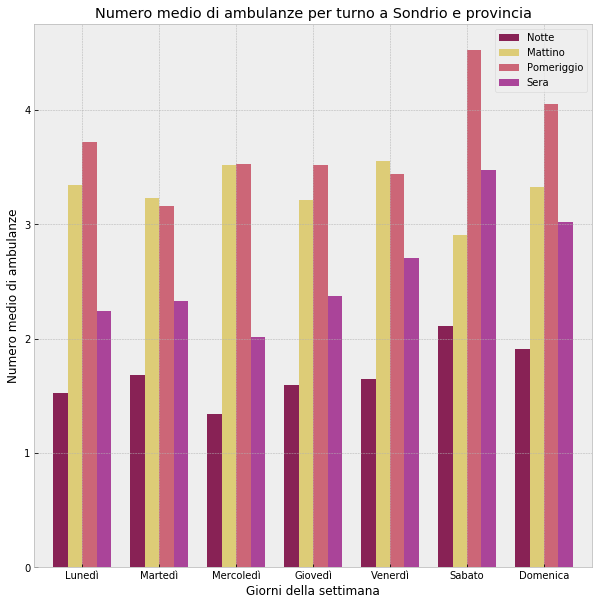

In [57]:
#Creiamo il dataframe contenente i dati che vogliamo analizzare
sondrio = read_data("sondrio")
medie = sondrio.copy()
medie["hour"] = medie["hour"].astype(int).floordiv(6);
medie = medie[["msb", "weekday", "hour"]].groupby(["weekday", "hour"]).mean().unstack(1)

#Cambiamo i valori del dataframe con nomi più appropiati
medie.rename(columns={0:"Notte",1:"Mattina",2:"Pomeriggio",3:"Sera"}, inplace=True)
medie.rename(index={"0":"7"}, inplace=True)
medie.sort_index(inplace=True)
medie.rename(index={"7":"Domenica","1":"Lunedì","2":"Martedì","3":"Mercoledì", "4":"Giovedì","5":"Venerdì","6":"Sabato"}, inplace=True)
ax = medie.plot(kind="bar", width=0.75, color=["#882255", "#DDCC77","#CC6677","#AA4499"], xlabel="Giorni della settimana", ylabel="Numero medio di ambulanze", title="Numero medio di ambulanze per turno a Sondrio e provincia")
ax.legend(["Notte", "Mattino", "Pomeriggio", "Sera"]);
plt.xticks(rotation=0)
plt.show()

Notiamo un'altra cosa strana di Sondrio: gli infortuni sono molti di più rispetto alle altre province.

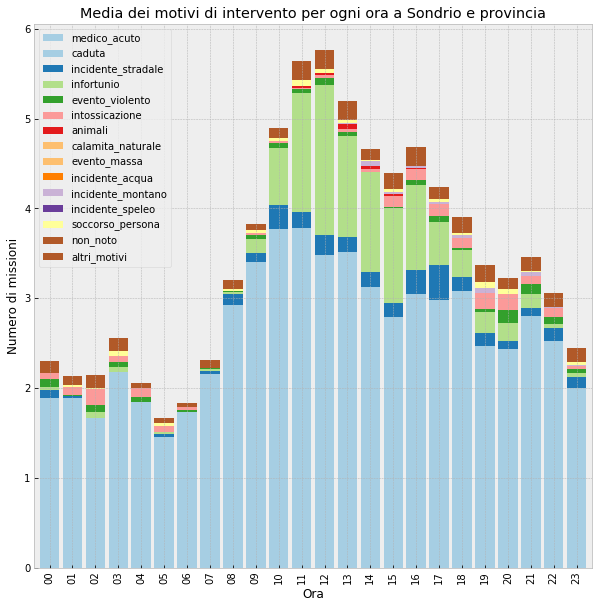

In [60]:
orari = sondrio[["medico_acuto", "caduta", "incidente_stradale", "infortunio", "evento_violento", "intossicazione", "animali", "calamita_naturale", "evento_massa", "incidente_acqua", "incidente_montano", "incidente_speleo", "soccorso_persona", "non_noto", "altri_motivi"]]
orari = orari.groupby(by= sondrio["hour"]).mean()
_ = orari.plot(kind="bar", stacked=True, width=0.85, colormap="Paired")
plt.ylabel('Numero di missioni')
plt.xlabel('Ora')
plt.title('Media dei motivi di intervento per ogni ora a Sondrio e provincia')
plt.show()

## TODO
🌧️ Aggiungere condizioni meteo

🐙 Motivi di intervento maggiori per ora + giorno della settimana (e magari per il meteo)